In [1]:
import math
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
# import plotly.express as px

from scipy.signal import argrelmax, argrelmin, butter, filtfilt, find_peaks
from scipy import integrate
from sklearn.preprocessing import normalize, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
SAMPLING_FREQ = 970

### Data

In [3]:
# data = pd.read_csv("C:/Users/concu/OneDrive/Documents/usyd_/INFO-Honours/CLab/X000.txt", delim_whitespace=True, header=None)
data = pd.read_csv("E:/JY/X000.txt", delim_whitespace=True, header=None)
data.columns = ['I', 'II', 'III', 'aVF', 'V1', 'ART1', 'Stim', 'Pace']

In [4]:
data.head()

,I,II,III,aVF,V1,ART1,Stim,Pace
0,-0.050,0.005,0.054,0.010,2.016,6.013,-5.443,-0.050
1,-0.050,0.010,0.049,0.010,2.016,6.013,-5.443,-0.011
2,-0.040,0.015,0.039,0.000,2.016,5.988,-5.443,0.034
3,-0.030,0.000,0.029,-0.007,2.016,5.988,-5.443,0.057
4,-0.015,0.010,0.020,-0.005,2.016,6.013,-5.443,0.085


In [5]:
len(data)

4440991

## Visualisation

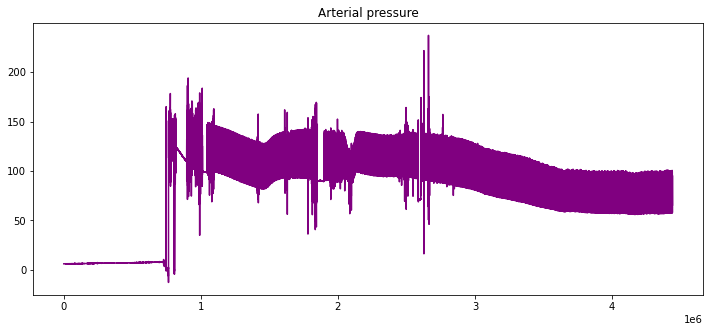

In [6]:
plt.figure(figsize=(12,5))
plt.plot(data.drop(columns=['I', 'II', 'III', 'aVF', 'V1', 'Stim', 'Pace']), 'purple')
plt.title('Arterial pressure')
plt.show()

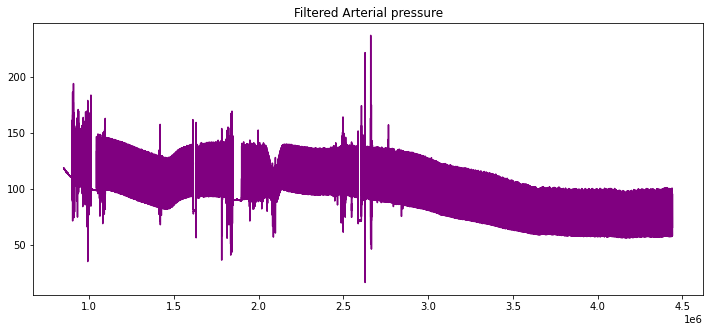

In [7]:
data = data.iloc[850000:]
plt.figure(figsize=(12,5))
plt.plot(data.drop(columns=['I', 'II', 'III', 'aVF', 'V1', 'Stim', 'Pace']), 'purple')
plt.title('Filtered Arterial pressure')
plt.show()

Text(0.5, 1.0, 'V1')

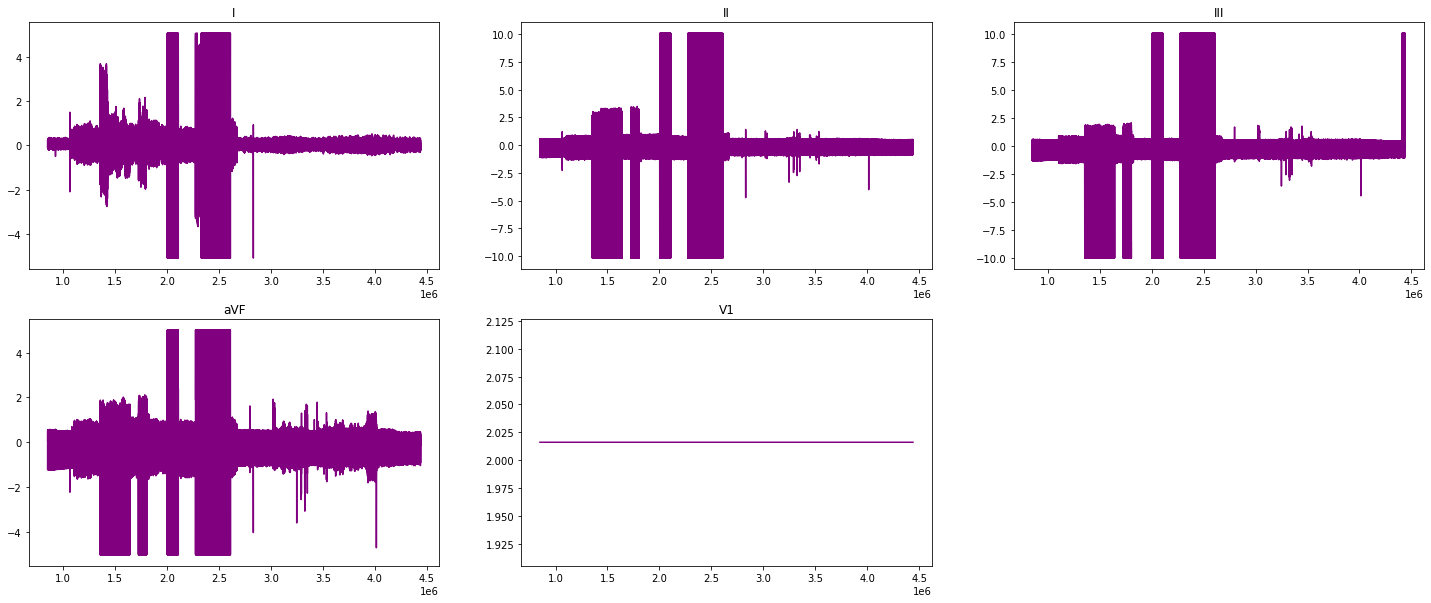

In [8]:
plt.figure(figsize=(25,10))

plt.subplot(2,3,1)
plt.plot(data.drop(columns=['II', 'III', 'aVF', 'V1', 'ART1', 'Stim', 'Pace']), 'purple')
plt.title('I')

plt.subplot(2,3,2)
plt.plot(data.drop(columns=['I', 'III', 'aVF', 'V1', 'ART1', 'Stim', 'Pace']), 'purple')
plt.title('II')

plt.subplot(2,3,3)
plt.plot(data.drop(columns=['I', 'II', 'aVF', 'V1', 'ART1', 'Stim', 'Pace']), 'purple')
plt.title('III')

plt.subplot(2,3,4)
plt.plot(data.drop(columns=['I', 'II', 'III', 'V1', 'ART1', 'Stim', 'Pace']), 'purple')
plt.title('aVF')

plt.subplot(2,3,5)
plt.plot(data.drop(columns=['I', 'II', 'III', 'aVF', 'ART1', 'Stim', 'Pace']), 'purple')
plt.title('V1')

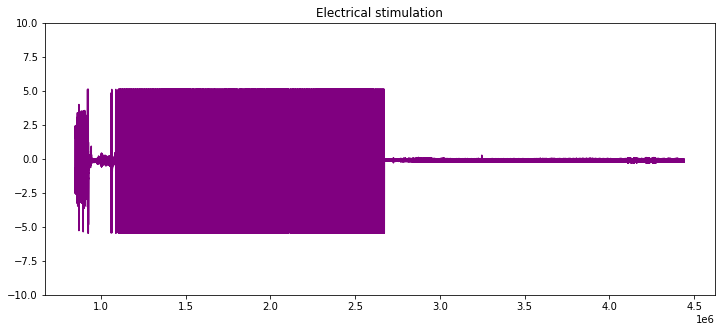

In [9]:
plt.figure(figsize=(12,5))
plt.plot(data.drop(columns=['I', 'II', 'III', 'aVF', 'V1', 'ART1', 'Pace']), 'purple')
plt.title('Electrical stimulation')
plt.ylim(-10,10)
plt.show()

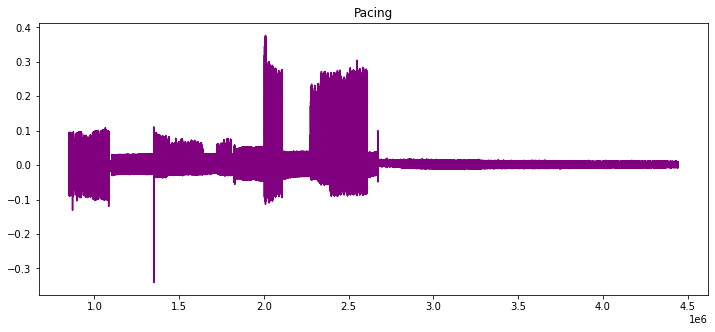

In [10]:
plt.figure(figsize=(12,5))
plt.plot(data.drop(columns=['I', 'II', 'III', 'aVF', 'V1', 'ART1', 'Stim']), 'purple')
plt.title('Pacing')
plt.show()

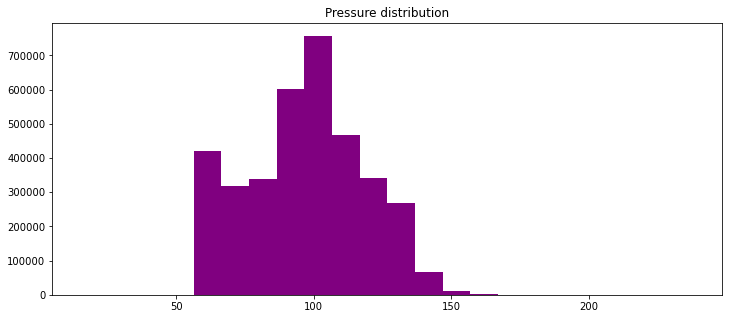

In [11]:
plt.figure(figsize=(12,5))
plt.hist(data['ART1'], bins=22, color='purple')
plt.title("Pressure distribution")
plt.show()

## Preprocessing

In [12]:
def apply_butter(lowcut, highcut, sf, order=4):
    nyq = 0.5 * sf
    low = lowcut / nyq
    high = highcut / nyq
    a, b = butter(order, [low, high], btype='band')

    return a, b

def apply_filter(signal):
    # CLab 970 sps
    a, b = apply_butter(0.5, 400, SAMPLING_FREQ, order=4)

    return filtfilt(a, b, signal)

In [13]:
filtered_i = apply_filter(data['I'].values)

(-0.25, 0.25)

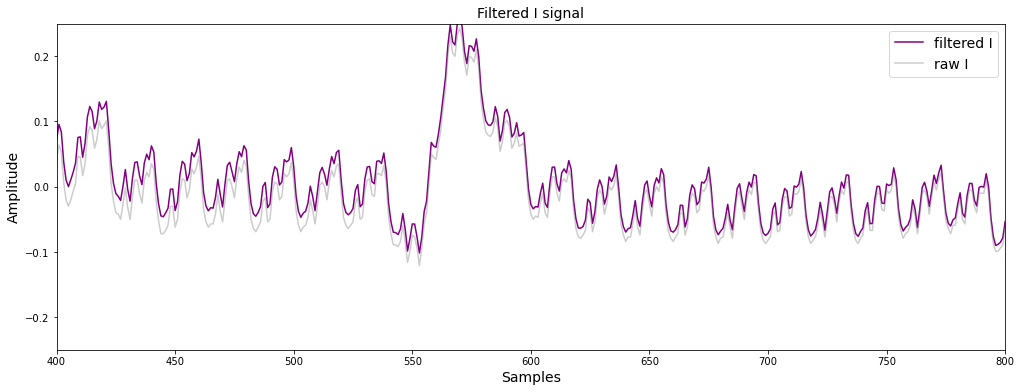

In [14]:
plt.figure(figsize=(17,6))

plt.plot(filtered_i, label='filtered I', c='purple')
plt.plot(np.array(data['I']), c='gray', alpha=0.4, label="raw I")
plt.title("Filtered I signal", fontsize=14)
plt.xlabel("Samples", fontsize=14)
plt.ylabel("Amplitude", fontsize=14)
plt.legend(prop={'size':14})
plt.xlim(400,800)
plt.ylim(-0.25,0.25)


In [15]:
filtered_aVF = apply_filter(data['aVF'].values)

(-0.4, 0.4)

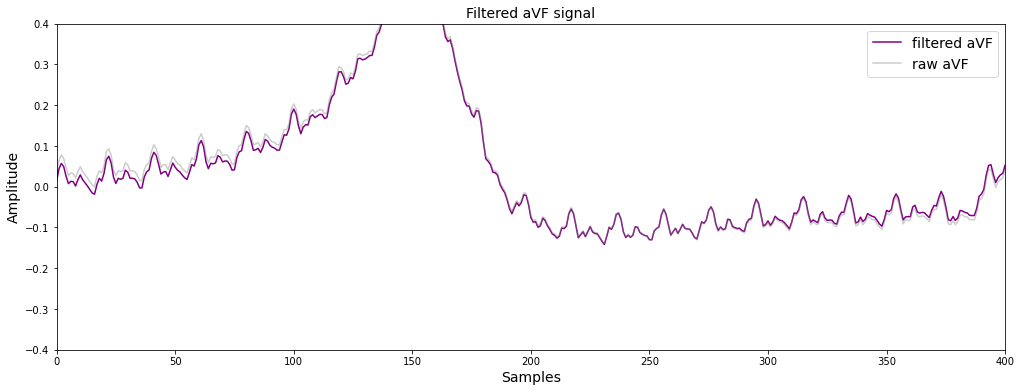

In [16]:
plt.figure(figsize=(17,6))

plt.plot(filtered_aVF, label='filtered aVF', c='purple')
plt.plot(np.array(data['aVF']), c='gray', alpha=0.4, label="raw aVF")
plt.title("Filtered aVF signal", fontsize=14)
plt.xlabel("Samples", fontsize=14)
plt.ylabel("Amplitude", fontsize=14)
plt.legend(prop={'size':14})
plt.xlim(0,400)
plt.ylim(-0.4,0.4)


In [17]:
def peak(signal):
    # Maxima identified peaks in entire signal
    return find_peaks(signal, distance=15)[0]

def dip(signal):
    # Minima identified peaks in entire signal
    return find_peaks(-1*signal, height=0, distance=15)[0]

def beat_segmentation(signal):
    beats, tops, p = [], [], []
    peaks = peak(signal)
    dips = dip(signal)
    
    for i in range(len(dips)-1):
        start = dips[i]
        end = dips[i+1]
        segment = np.arange(start, end)
        l = [p in peaks for p in segment]
        
        # One peak between minima identifies it as a beat
        if list(map(bool, l)).count(True) == 1: 
            # Normalisation w reshaping
            bshape = signal[segment].shape
            normalized_beat = normalize(signal[segment].reshape(1, -1))
            beats.append(normalized_beat.reshape(bshape))
            tops.append(np.where(l)[0][0])
            p.append(i)
            
    return beats, tops, p

(-0.5, 0.5)

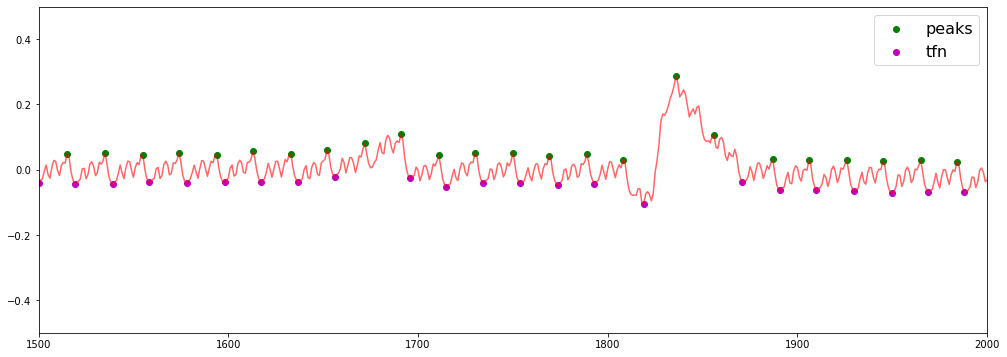

In [18]:
peaks_i = peak(filtered_i)
tfns_i = dip(filtered_i)

plt.figure(figsize=(17,6))
plt.plot(filtered_i, c="r", alpha=0.6)

plt.scatter(peaks_i, filtered_i[peaks_i], c="g", label="peaks")
plt.scatter(tfns_i, filtered_i[tfns_i], c="m", label="tfn")
plt.legend(prop={'size':16})
plt.xlim(1500,2000)
plt.ylim(-0.5,0.5)

(-0.5, 0.5)

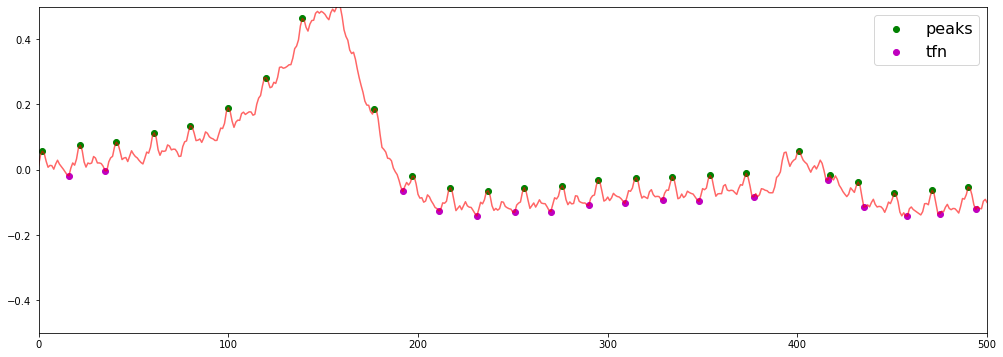

In [19]:
peaks_aVF = peak(filtered_aVF)
tfns_aVF = dip(filtered_aVF)

plt.figure(figsize=(17,6))
plt.plot(filtered_aVF, c="r", alpha=0.6)

plt.scatter(peaks_aVF, filtered_aVF[peaks_aVF], c="g", label="peaks")
plt.scatter(tfns_aVF, filtered_aVF[tfns_aVF], c="m", label="tfn")
plt.legend(prop={'size':16})
plt.xlim(0,500)
plt.ylim(-0.5,0.5)

In [20]:
beats, peaks, pressures = beat_segmentation(filtered_aVF)

In [21]:
# https://affect.media.mit.edu/pdfs/14.McDuff_et_al_Remote.pdf
# Modified from PPG waves
def dicrotic_notch(beat, peak):
    derivative = np.diff(np.diff(beat[peak:]))
    point = find_peaks(derivative)[0]
    corrected = 0
    
    if len(point) > 0:
        corrected =  peak + point[-1]
        
    return corrected

def diastolic_peak(beat, systolic):
    derivative = np.diff(np.diff(beat[systolic:]))
    point = find_peaks(derivative*(-1))[0]
    corrected = 0
    
    if len(point) > 0:
        corrected = systolic + point[-1]
        if abs(beat[corrected]) >= abs(1.01*beat[corrected - 1]):
            return corrected
        else:
            return 0
        
    return corrected

def p_wave(beat):
    relmax = argrelmax(beat)[0]
    if (len(relmax) > 0):
        return relmax[0]
    else:
        return 0

def q_wave(beat):
    relmin = argrelmin(beat)[0]
    if (len(relmin) > 0):
        return relmin[0]
    else:
        return 0

# R wave found by peak algorithm

def s_wave(beat):
    relmin = argrelmin(beat)[0]
    if (len(relmin) > 1):
        return relmin[1]
    else:
        return 0

def t_wave(beat):
    relmax = argrelmax(beat)[0]

    # Noisy beat
    if (len(relmax) > 2):
        return relmax[2]
    else:
        return 0

In [50]:
def peaks_detection(beats, peaks, pressure):    
    dicrotics, diastolics, p, q, s, t, pressures = [], [], [], [], [], [], []
    
    for a, b, c in zip(beats, peaks, pressure):
        dicrotics.append(dicrotic_notch(a,b))
        diastolics.append(diastolic_peak(a,b))
        p.append(p_wave(a))
        q.append(q_wave(a))
        s.append(s_wave(a))
        t.append(t_wave(a))
        pressures.append(data['ART1'][c+850000])

    result = np.array([beats, peaks, p, q, s, t, dicrotics, diastolics, pressures], dtype=object)
    # Remove features (dicrotics / diastolics) not found
    result = result[..., result[2] > 0]
    result = result[..., result[3] > 0]
    result = result[..., result[4] > 0]
    result = result[..., result[5] > 0]
    result = result[..., result[6] > 0]
    result = result[..., result[7] > 0]
    
    # Output shape (4, nb) where nb is number of beats
    return result.T

In [51]:
beats_features = peaks_detection(beats, peaks, pressures)

(array([-0.12553021,  0.03203231,  0.14140431,  0.09468757,  0.2237389 ,
        0.45078612,  0.50981223,  0.39908956,  0.16107702,  0.05477607,
        0.14001028,  0.12485303,  0.14074431,  0.27598719,  0.24360293,
        0.14143073,  0.14167642,  0.12937581,  0.0744067 ]), 6, 2, 3, 9, 10, 14, 12, 118.388)


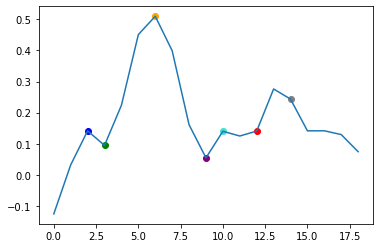

(array([-0.19512673, -0.15280802, -0.11485267, -0.13802909, -0.11381726,
       -0.05857332, -0.06308122, -0.12844539, -0.22228418, -0.25629114,
       -0.25249872, -0.29286651, -0.28243664, -0.22680107, -0.24435097,
       -0.28180597, -0.30857933, -0.34082284, -0.35090603]), 5, 2, 3, 9, 10, 14, 15, 118.413)


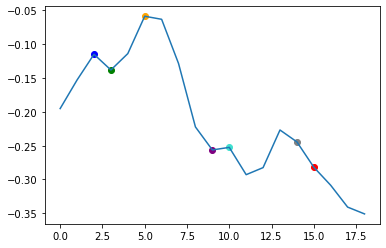

(array([-0.26152052, -0.25145907, -0.2105955 , -0.21297263, -0.20038917,
       -0.13781563, -0.11315762, -0.13745673, -0.19967138, -0.25966183,
       -0.24432569, -0.22894171, -0.25365329, -0.2291641 , -0.20314626,
       -0.22920167, -0.237673  , -0.23943928, -0.25804617, -0.27812204]), 6, 2, 3, 9, 11, 14, 16, 118.388)


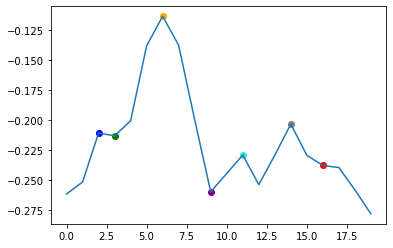

(array([-0.28770852, -0.24726801, -0.20252541, -0.21245042, -0.18741312,
       -0.13790476, -0.13130996, -0.16257672, -0.22422913, -0.25319498,
       -0.24098767, -0.25171201, -0.24194436, -0.19929454, -0.2022059 ,
       -0.2285084 , -0.23679208, -0.24259371, -0.24579231, -0.2638192 ]), 6, 2, 3, 9, 10, 16, 15, 118.413)


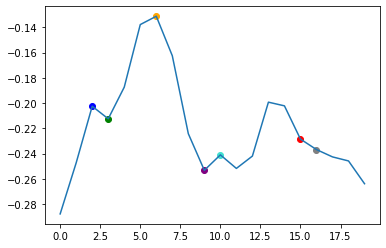

(array([-0.29140206, -0.24282451, -0.22920415, -0.22124367, -0.15621662,
       -0.12314034, -0.1509452 , -0.21001579, -0.26533664, -0.24666612,
       -0.22813029, -0.25638144, -0.23304876, -0.20624877, -0.2285702 ,
       -0.23236021, -0.23314375, -0.25388032, -0.27795656]), 5, 5, 8, 11, 13, 13, 15, 118.425)


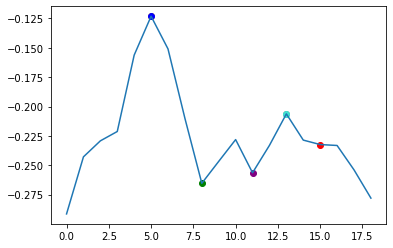

(array([-0.30584239, -0.25538892, -0.20538713, -0.21412464, -0.19348899,
       -0.13674272, -0.117609  , -0.14715684, -0.21868089, -0.25547242,
       -0.2356872 , -0.25012845, -0.24694379, -0.19068056, -0.19326539,
       -0.23175842, -0.23962257, -0.2443257 , -0.24309788, -0.25644794]), 6, 2, 3, 9, 10, 16, 15, 118.4)


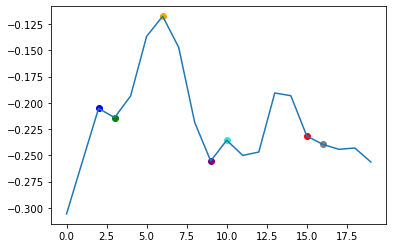

(array([-0.31020707, -0.24913142, -0.22593287, -0.21932   , -0.13564553,
       -0.08585824, -0.11488916, -0.19087368, -0.27197031, -0.26184042,
       -0.2370324 , -0.26746032, -0.2447582 , -0.20487997, -0.22190562,
       -0.23210777, -0.23645477, -0.25057822, -0.27056998]), 5, 5, 8, 11, 13, 13, 15, 118.425)


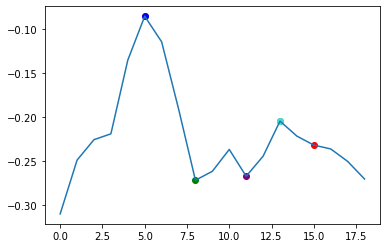

(array([-0.29396153, -0.2305763 , -0.19979888, -0.2020527 , -0.12803616,
       -0.06775817, -0.09525288, -0.18527016, -0.28497899, -0.27564079,
       -0.23871489, -0.27307951, -0.25575662, -0.2108418 , -0.22362311,
       -0.23274144, -0.23889706, -0.26474048, -0.29213822]), 5, 2, 3, 8, 10, 13, 15, 118.375)


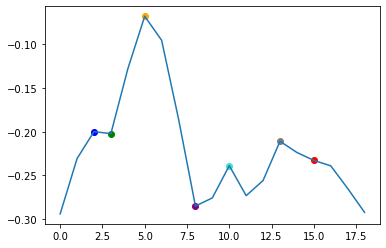

(array([-0.29276397, -0.25752628, -0.29029231, -0.26907614, -0.20444635,
       -0.20939259, -0.22139251, -0.22606068, -0.24636152, -0.24878108,
       -0.24745306, -0.18700686, -0.08306013, -0.06275174, -0.02339094,
        0.09996458,  0.18343173,  0.18951581,  0.10545014,  0.03618168,
        0.07805124,  0.10216415,  0.11583212,  0.1878563 ,  0.20679556,
        0.15094637,  0.10358731,  0.08028886,  0.06200975,  0.01475925,
       -0.0266317 ,  0.01686157,  0.04265006,  0.00777237,  0.04989005,
        0.10284077,  0.06842678, -0.00942576, -0.10315885]), 24, 1, 2, 9, 17, 32, 34, 118.388)


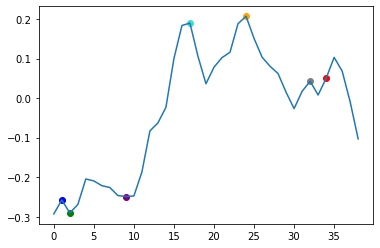

(array([-0.22900653, -0.21478648, -0.22157492, -0.1922966 , -0.16894342,
       -0.19109121, -0.20055449, -0.19031506, -0.18486486, -0.19719648,
       -0.21025461, -0.17601629, -0.12696263, -0.12370508, -0.11737754,
       -0.09004193, -0.08951624, -0.11444404, -0.1690731 , -0.20468078,
       -0.19080067, -0.20745132, -0.2244825 , -0.19601523, -0.19742502,
       -0.22513953, -0.23840925, -0.25679319]), 16, 1, 2, 6, 8, 24, 22, 118.363)


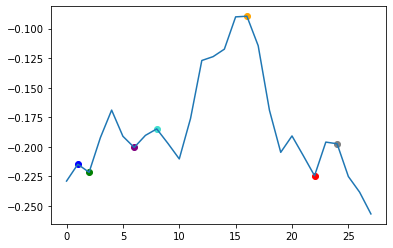

(array([-0.27074597, -0.18646304, -0.16911249, -0.21019054, -0.22769216,
       -0.22872288, -0.2088117 , -0.21473689, -0.20594429, -0.13240806,
       -0.121226  , -0.13487768, -0.04458442,  0.02184818, -0.02781611,
       -0.12856291, -0.21501083, -0.20246324, -0.17600612, -0.21854017,
       -0.1944613 , -0.15978688, -0.20262405, -0.21703001, -0.22197903,
       -0.2497233 , -0.28909515]), 13, 2, 5, 7, 10, 21, 23, 118.338)


In [52]:
# Visualize detected peaks for lead I
i = 0
for beat, peak, p, q, s, t, dicrotic, diastolic, pressure in beats_features:
    print((beat, peak, p, q, s, t, dicrotic, diastolic, pressure))
    if (i == 10):
        break
    plt.figure()
    plt.plot(beat)
    plt.scatter(peak,beat[peak], c="orange")
    plt.scatter(diastolic,beat[diastolic], c= "red")
    plt.scatter(dicrotic,beat[dicrotic], c= "gray")
    plt.scatter(p, beat[p], c="blue")
    plt.scatter(q, beat[q], c="green")
    plt.scatter(s, beat[s], c="purple")
    plt.scatter(t, beat[t], c="turquoise")
    plt.show()
    i += 1

## Feature extraction

In [53]:
def heart_rate(signal, sf=SAMPLING_FREQ):
    # return 60/t*peak(signal)
    return len(peaks_i)/(len(signal)/sf)

# Derived from PPG as an indication of systolic-diastolic amplitude ratio
def reflection_index(beat, systolic, diastolic):
    a = beat[systolic] - np.min(beat)
    b = a - (beat[diastolic] - np.min(beat))
    
    return a/b

def beat_timespan(dicrotic, sf=SAMPLING_FREQ):
    return dicrotic/sf

def up_time(peak, sf=SAMPLING_FREQ):
    return peak/sf

def pq_interval(p, q, sf=SAMPLING_FREQ):
    return (q-p)/sf

def qrs_duration(q, s, sf=SAMPLING_FREQ):
    return (s-q)/sf

def st_segment(s, t, sf=SAMPLING_FREQ):
    return (t-s)/sf

def qt_interval(q, t, sf=SAMPLING_FREQ):
    return (t-q)/sf

# https://www.reddit.com/r/askscience/comments/iuxuv/im_curious_what_does_the_area_under_an_ecg_curve/
def up_volume(beat, dicrotic, sf=SAMPLING_FREQ):
    try:
        return integrate.simps(beat[:dicrotic], dx=1/sf)
    except:
        return 0

def down_volume(beat, dicrotic, sf=SAMPLING_FREQ):
    try:
        return integrate.simps(beat[dicrotic:], dx=1/sf)
    except:
        return 0

In [54]:
def feature_extraction(signal, beats, sf=SAMPLING_FREQ):
    # dataset = pd.DataFrame({
    #     'hr': pd.Series(dtype='float'),
    #     'ri': pd.Series(dtype='float'),
    #     'bt': pd.Series(dtype='float'),
    #     'ut': pd.Series(dtype='float'),
    #     'pq': pd.Series(dtype='float'),
    #     'qrs': pd.Series(dtype='float'),
    #     'st': pd.Series(dtype='float'),
    #     'qt': pd.Series(dtype='float'),
    #     'sv': pd.Series(dtype='float'),
    #     'dv': pd.Series(dtype='float'),
    #     'pressure': pd.Series(dtype='float')
    # })
    
    features, dataset = [], []

    hr = heart_rate(signal, sf)
    for beat, peak, p, q, s, t, dicrotic, diastolic, pressure in beats:
        ri = reflection_index(beat, peak, diastolic)
        bt = beat_timespan(dicrotic, sf)
        ut = up_time(peak, sf)
        pq = pq_interval(p, q, sf)
        qrs = qrs_duration(q, s, sf)
        st = st_segment(s, t, sf)
        qt = qt_interval(q, t, sf)
        sv = up_volume(beat, dicrotic, sf)
        dv = down_volume(beat, dicrotic, sf)

        features.append([hr, ri, bt, ut, pq, qrs, st, qt, sv, dv])
        dataset.append([hr, ri, bt, ut, pq, qrs, st, qt, sv, dv, pressure])
        # new_beat = {
        #     'hr':hr,
        #     'ri':ri,
        #     'bt':bt,
        #     'ut':ut,
        #     'pq':pq,
        #     'qrs':qrs,
        #     'st':st,
        #     'qt':qt,
        #     'sv':sv,
        #     'dv':dv,
        #     'pressure':pressure
        # }
        # dataset = dataset.append(new_beat, ignore_index=True)

    return np.array(features), np.array(dataset)

In [55]:
features, dataset = feature_extraction(filtered_aVF, beats_features, SAMPLING_FREQ)

features.shape

(28756, 10)

In [56]:
dataset.shape

(28756, 11)

## Dataset

In [57]:
train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=27)
print(f"Train examples: {train_data.shape}")
print(f"Test examples: {test_data.shape}")

Train examples: (23004, 11)
Test examples: (5752, 11)


In [58]:
def signal_in(sample, scaler, fit=True):
    sf = SAMPLING_FREQ
    filtered_aVF = apply_filter(sample)
    beats, peaks = beat_segmentation(filtered_aVF)
    beats_features = peaks_detection(beats, peaks)
    features, dataset = feature_extraction(filtered_aVF, beats_features, sf)
    if fit:
        scaler.partial_fit(features)
    return features, dataset

def dataprep(sample, scaler, fit=True):
    training = np.array([signal_in(sample, scaler, fit)])
    return training

In [59]:
x_train, y_train = [], []
for t in train_data:
    features = []
    for k in range(len(t)):
        if k < 10:
            features.append(t[k])
        else:
            y_train.append(t[k])
    x_train.append(features)

x_test, y_test = [], []
for t in test_data:
    features = []
    for k in range(len(t)):
        if k < 10:
            features.append(t[k])
        else:
            y_test.append(t[k])
    x_test.append(features)

In [60]:
print(x_train[0])

[49.24295271138246, 1.7231113578440012, 0.01443298969072165, 0.007216494845360825, 0.002061855670103093, 0.005154639175257732, 0.002061855670103093, 0.007216494845360825, 0.0027856429619202354, 0.0003640758548743512]


In [61]:
# https://machinelearningmastery.com/how-to-scale-data-for-long-short-term-memory-networks-in-python/
s_scaler = StandardScaler()
r_scaler = RobustScaler()
m_scaler = MinMaxScaler()

norm_x_train = s_scaler.fit_transform(x_train)
norm_x_test = s_scaler.fit_transform(x_test)

In [62]:
print(norm_x_train[0])

[-1.         -0.06684495 -0.21728221 -0.49608618  0.21946812 -0.13413194
 -0.04400821 -0.14723343  1.20985041  1.03336083]


In [63]:
print(y_train[0])

115.275


In [64]:
scal_y_train = m_scaler.fit_transform(np.reshape(y_train, (1, 23004)).T)
scal_y_test = m_scaler.fit_transform(np.reshape(y_test, (1, 5752)).T)
# scal_y_train = np.reshape(y_train, (1, 88248)).T
# scal_y_test = np.reshape(y_test, (1, 22063)).T

In [65]:
print(scal_y_train[0])

[0.48302444]


## Model

In [78]:
from tensorflow.keras.layers import Masking, Bidirectional, Dropout, LSTM, Add, Dense
from tensorflow.keras import Input, Model
from tensorflow.keras.optimizers import Adam
from keras.metrics import RootMeanSquaredError

from keras_preprocessing.sequence import pad_sequences

In [79]:
x = []
for k in norm_x_train:
    for i in k:
        x.append(i)
np.array(x).shape

(230040,)

In [80]:
x_train_pad = pad_sequences(norm_x_train, maxlen=640, padding='post', dtype='float64')
x_test_pad = pad_sequences(norm_x_test, maxlen=640, padding='post', dtype='float64')

In [81]:
x_train_pad = x_train_pad.reshape(x_train_pad.shape[0],64,10)
x_test_pad = x_test_pad.reshape(x_test_pad.shape[0],64,10)

In [82]:
print(f"Training features shape: {norm_x_train.shape}")
print(f"Padded training shape: {np.array(x_train_pad).shape}")
print(f"Training label shape: {np.array(scal_y_train).shape}")

Training features shape: (23004, 10)
Padded training shape: (23004, 64, 10)
Training label shape: (23004, 1)


In [83]:
max_time = x_train_pad.shape[1]
num_features = 10
# x_train_pad = x_train_pad.reshape(x_train_pad.shape[0], x_train_pad.shape[1], num_features)

In [89]:
inputs = Input(shape=(max_time, num_features))

x = Masking(mask_value=0, input_shape=(max_time, num_features))(inputs)

x = Bidirectional(LSTM(128, return_sequences=True))(x)
x = Dropout(rate=0.5)(x)

x = LSTM(128, return_sequences=True)(x)
x = Dropout(rate=0.5)(x)

x_shortcut2 = LSTM(128, return_sequences=True)(x)
x_shortcut2 = Dropout(rate=0.5)(x_shortcut2)
x = Add()([x, x_shortcut2])

x_shortcut3 = LSTM(128, return_sequences=True)(x)
x_shortcut3 = Dropout(rate=0.5)(x_shortcut3)
x = Add()([x, x_shortcut3])

x = LSTM(128, return_sequences=False)(x)
x = Dropout(rate=0.5)(x)

outputs = Dense(units=1, activation='relu')(x)

model = Model(inputs, outputs)

In [90]:
model.summary(line_length=100)

Model: "model_1"
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_5 (InputLayer)             [(None, 64, 10)]      0                                            
____________________________________________________________________________________________________
masking_1 (Masking)              (None, 64, 10)        0           input_5[0][0]                    
____________________________________________________________________________________________________
bidirectional_1 (Bidirectional)  (None, 64, 256)       142336      masking_1[0][0]                  
____________________________________________________________________________________________________
dropout_5 (Dropout)              (None, 64, 256)       0           bidirectional_1[0][0]            
__________________________________________________________________________

In [91]:
opti = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, decay=0.01)
model.compile(optimizer=opti,
              loss='mean_absolute_error',
              metrics=[RootMeanSquaredError()])

In [92]:
history = model.fit(x_train_pad, scal_y_train, batch_size=64, epochs=60)

Epoch 1/60
360/360 [==============================] - 184s 463ms/step - loss: 0.0905 - root_mean_squared_error: 0.1964
Epoch 2/60
360/360 [==============================] - 165s 459ms/step - loss: 0.0655 - root_mean_squared_error: 0.1230
Epoch 3/60
360/360 [==============================] - 169s 470ms/step - loss: 0.0635 - root_mean_squared_error: 0.1105
Epoch 4/60
360/360 [==============================] - 167s 463ms/step - loss: 0.0623 - root_mean_squared_error: 0.1049
Epoch 5/60
360/360 [==============================] - 168s 466ms/step - loss: 0.0614 - root_mean_squared_error: 0.1014
Epoch 6/60
360/360 [==============================] - 167s 465ms/step - loss: 0.0610 - root_mean_squared_error: 0.0991
Epoch 7/60
360/360 [==============================] - 169s 471ms/step - loss: 0.0604 - root_mean_squared_error: 0.0974
Epoch 8/60
360/360 [==============================] - 170s 473ms/step - loss: 0.0600 - root_mean_squared_error: 0.0960
Epoch 9/60
360/360 [============================

## Evaluation

In [93]:
eval_train = model.predict(x_train_pad)
eval_test = model.predict(x_test_pad)

In [94]:
eval_train

array([[0.4770593 ],
       [0.4762385 ],
       [0.5042705 ],
       ...,
       [0.47304082],
       [0.49639124],
       [0.4744364 ]], dtype=float32)

In [95]:
inv_eval_train = m_scaler.inverse_transform(eval_train)
inv_eval_test = m_scaler.inverse_transform(eval_test)
inv_eval_train

array([[118.55864 ],
       [118.48268 ],
       [121.07668 ],
       ...,
       [118.186775],
       [120.34756 ],
       [118.31592 ]], dtype=float32)

In [96]:
train_eval, test_eval = [], []
for k in inv_eval_train:
    train_eval.append(k[0])
for k in inv_eval_test:
    test_eval.append(k[0])

In [97]:
train_score = math.sqrt(mean_squared_error(y_train, train_eval))
test_score = math.sqrt(mean_squared_error(y_test, test_eval))

print("Train Score RMSE (mmHg): %.4f" % (train_score))
print("Test Score RMSE (mmHg): %.4f" % (test_score))

Train Score RMSE (mmHg): 11.6337
Test Score RMSE (mmHg): 11.6076


Text(0.5, 0, 'Epoch')

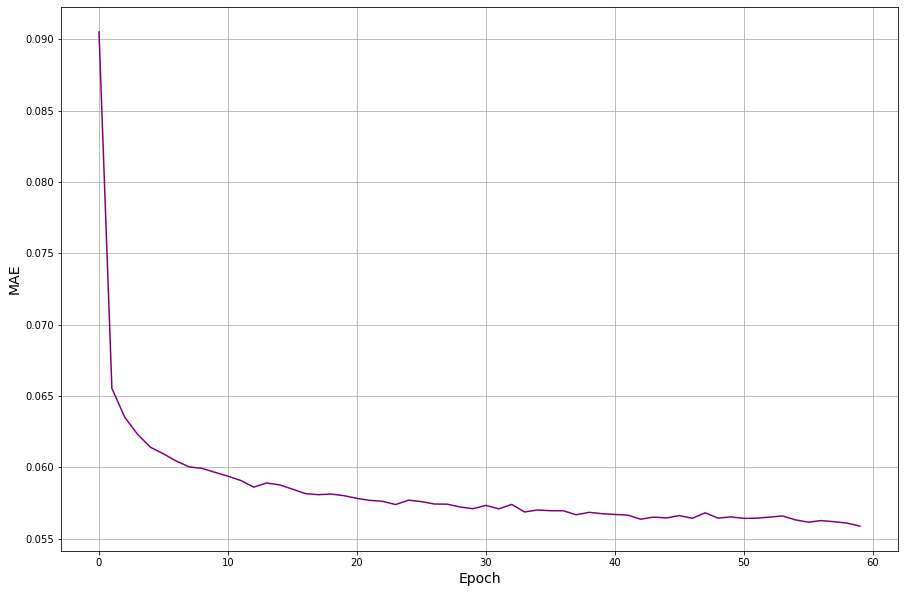

In [98]:
plt.figure(figsize=(15,10))
plt.plot(history.history['loss'], c='purple')
plt.grid()
plt.ylabel('MAE',fontsize=14)
plt.xlabel('Epoch', fontsize=14)

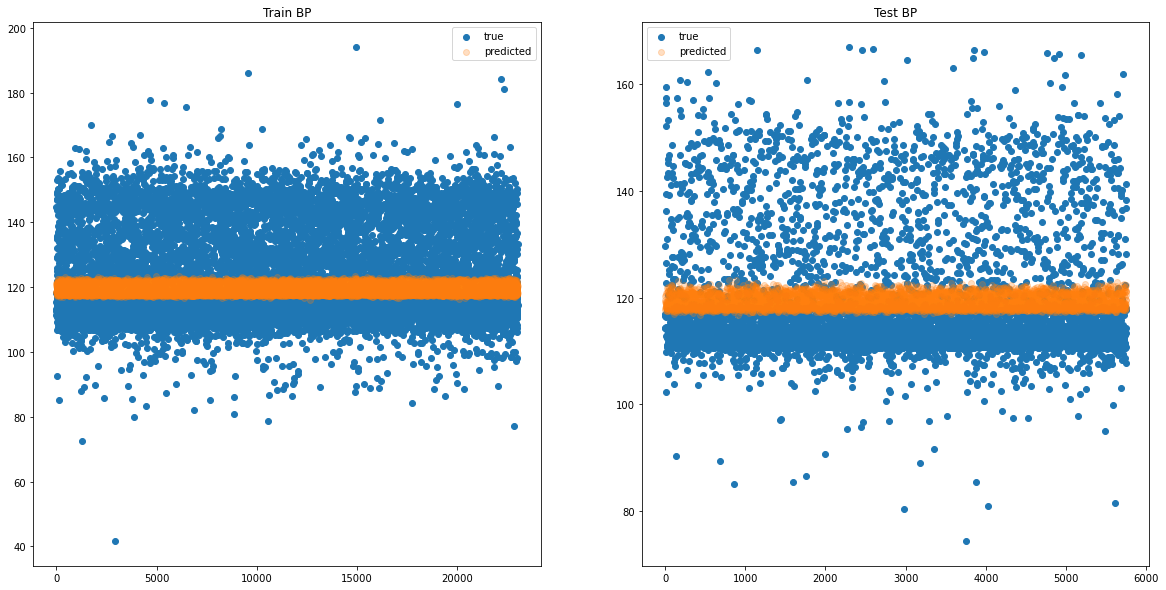

In [99]:
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
axisy = np.arange(len(train_eval))
plt.scatter(axisy, y_train, label='true')
plt.scatter(axisy, train_eval, label='predicted', alpha=0.25)
plt.title('Train BP')
# plt.ylim(20,115)
plt.legend()

plt.subplot(1,2,2)
axisy = np.arange(len(test_eval))
plt.scatter(axisy, y_test, label='true')
plt.scatter(axisy, test_eval, label='predicted', alpha=0.25)
plt.title('Test BP')
# plt.ylim(20,115)
plt.legend()

(-40.0, 50.0)

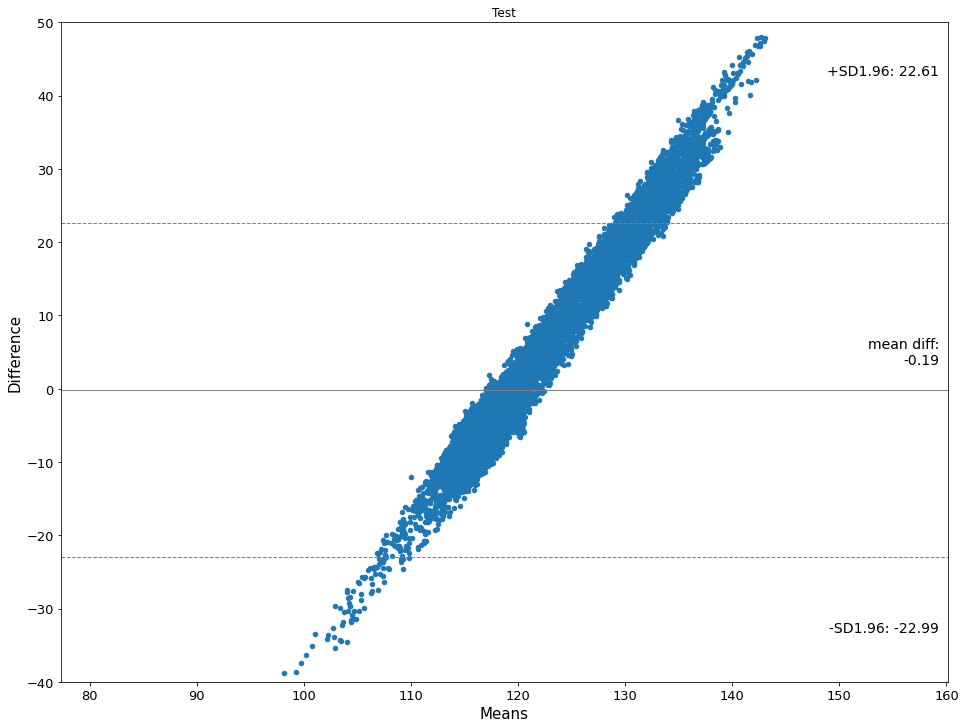

In [105]:
import statsmodels.api as sm

plt.figure(figsize=(26,10))
ax = plt.subplot(1,2,1)
sm.graphics.mean_diff_plot(np.array(y_train), np.array(train_eval), ax=ax)
plt.title('Test')
plt.ylim(-40,50)